# Import libraries

In [1]:
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

# Define functions

In [2]:
def change_cmap_bkg_to_white(colormap, n=256):
    tmp_colors = cm.get_cmap(colormap, n)
    newcolors = tmp_colors(np.linspace(0, 1, n))
    white = np.array([1, 1, 1, 1])    # White background (Red, Green, Blue, Alpha).
    newcolors[0, :] = white    # Only change bins with 0 entries.
    newcmp = colors.ListedColormap(newcolors)
    
    return newcmp

def my_hist2d(eff_hist, xedges, yedges, ax, cmap=None, colorbar=False):
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = eff_hist.T.ravel()
  cmap = change_cmap_bkg_to_white(cmap)
  h, edges, yedges, image = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=cmap, vmin=0.0, vmax=1.05)
  if colorbar:
    cb = plt.colorbar(image, ax=ax)#, norm=mpl.colors.Normalize(vmin=0.0, vmax=1.0),extend='both')
  return h, edges, yedges, image

z_ME2 = 808 # cm

def calcStar(eta_gen, phi_gen, vx, vy, vz):
    """Calculated etastar and phistar for a gen particle."""
    
    r = (z_ME2 - abs(vz))/abs(np.sinh(eta_gen))
    xStar = vx + r * np.cos(phi_gen)
    yStar = vy + r * np.sin(phi_gen)
    rStar = np.sqrt(xStar*xStar + yStar*yStar)
    
    etaStar_gen = np.arcsinh(z_ME2/rStar) * (eta_gen/abs(eta_gen))

    phiStar_gen = []
    for i,evt in enumerate(phi_gen):
        temp = evt.copy()
        temp = np.where(xStar[i] >= 0, np.arctan(yStar[i]/xStar[i]), temp)
        temp = np.where(np.logical_and(xStar[i] < 0, yStar[i] >= 0), np.pi + np.arctan(yStar[i]/xStar[i]), temp)
        temp = np.where(np.logical_and(xStar[i] < 0, yStar[i] < 0), np.arctan(yStar[i]/xStar[i]) - np.pi, temp)
        phiStar_gen.append(temp)
    phiStar_gen = awkward.fromiter(phiStar_gen)    
    
    return etaStar_gen, phiStar_gen

def global_pt(local_pt):
    global_pt = []
    for i,evt in enumerate(local_pt):
        temp = local_pt[i].copy()
        temp = temp*0.5
        global_pt.append(temp)
    return awkward.fromiter(global_pt)

def global_eta(local_eta):
    global_eta = []
    for i,evt in enumerate(local_eta):
        temp = local_eta[i].copy()
        temp = temp*0.010875
        global_eta.append(temp)
    return awkward.fromiter(global_eta)

def global_phi(emu_phi):
    global_phi = []
    for i,evt in enumerate(emu_phi):
        temp = emu_phi[i] / 576 *2*np.pi - np.pi*15/180
        temp = np.where(temp > np.pi, temp-2*np.pi, temp)
        global_phi.append(temp)
    return awkward.fromiter(global_phi)

# Open ROOT files with `uproot`

In [3]:
# filename = "/eos/cms/store/user/eyigitba/emtf/L1Ntuples/Run3/DisplacedMuons/L1Ntuple_HTo2LLTo4Mu_NNv4.root"
displaced_muon_sample = "./L1Ntuple.root"
HtoLLP_sample = "/eos/cms/store/user/eyigitba/emtf/L1Ntuples/Run3/crabOut/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV_pythia8/L1Ntuple_HTo2LLTo4Mu_cmssw_11_0_2_pTUnc_NNv4_noLUT/200703_130444/L1Ntuple_HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV_pythia8_NNv4_noLUT.root"

f_dm = uproot.open(displaced_muon_sample)
f_LLP = uproot.open(HtoLLP_sample)

dm_gen_tree  = f_dm['l1GeneratorTree/L1GenTree/Generator']
dm_emu_tree  = f_dm['l1UpgradeEmuTree/L1UpgradeTree/L1Upgrade']
dm_emtf_tree = f_dm['l1UpgradeTfMuonEmuTree/L1UpgradeTfMuonTree/L1UpgradeEmtfMuon']

LLP_gen_tree  = f_LLP['l1GeneratorTree/L1GenTree/Generator']
LLP_emu_tree  = f_LLP['l1UpgradeEmuTree/L1UpgradeTree/L1Upgrade']
LLP_emtf_tree = f_LLP['l1UpgradeTfMuonEmuTree/L1UpgradeTfMuonTree/L1UpgradeEmtfMuon']

# Define (1) gen, (2) emu, and (3) emtf variables

## (1)

In [4]:
%%time

dm_gen_id      = dm_gen_tree['partId'].array()
dm_id_mask     = np.abs(dm_gen_id) == 13 # Selects only muons in events
dm_gen_parent  = dm_gen_tree['partParent'].array()[dm_id_mask]
dm_gen_eta     = dm_gen_tree['partEta'].array()[dm_id_mask]
dm_gen_phi     = dm_gen_tree['partPhi'].array()[dm_id_mask]
dm_gen_pt      = dm_gen_tree['partPt'].array()[dm_id_mask]
dm_gen_z0      = dm_gen_tree['partVz'].array()[dm_id_mask]
dm_gen_x0      = dm_gen_tree['partVx'].array()[dm_id_mask]
dm_gen_y0      = dm_gen_tree['partVy'].array()[dm_id_mask]
dm_gen_charge  = dm_gen_tree['partCh'].array()[dm_id_mask]
dm_gen_dxy     = np.sqrt(dm_gen_x0**2 + dm_gen_y0**2)
dm_gen_etastar, dm_gen_phistar = calcStar(dm_gen_eta, dm_gen_phi, dm_gen_x0, dm_gen_y0, dm_gen_z0)

LLP_gen_id      = LLP_gen_tree['partId'].array()
LLP_id_mask     = np.abs(LLP_gen_id) == 13 # Selects only muons in events
LLP_gen_parent  = LLP_gen_tree['partParent'].array()
LLP_parent_mask = LLP_gen_parent == 6000113 # Selects muons specifically from LLP
id_parent_mask  = LLP_id_mask & LLP_parent_mask
LLP_gen_eta     = LLP_gen_tree['partEta'].array()[id_parent_mask]
LLP_gen_phi     = LLP_gen_tree['partPhi'].array()[id_parent_mask]
LLP_gen_pt      = LLP_gen_tree['partPt'].array()[id_parent_mask]
LLP_gen_z0      = LLP_gen_tree['partVz'].array()[id_parent_mask]
LLP_gen_x0      = LLP_gen_tree['partVx'].array()[id_parent_mask]
LLP_gen_y0      = LLP_gen_tree['partVy'].array()[id_parent_mask]
LLP_gen_charge  = LLP_gen_tree['partCh'].array()[id_parent_mask]
LLP_gen_dxy     = np.sqrt(LLP_gen_x0**2 + LLP_gen_y0**2)
LLP_gen_etastar, LLP_gen_phistar = calcStar(LLP_gen_eta, LLP_gen_phi, LLP_gen_x0, LLP_gen_y0, LLP_gen_z0)

CPU times: user 21.4 s, sys: 3.32 s, total: 24.8 s
Wall time: 24.5 s


## (2)

In [5]:
dm_emu_qual   = dm_emu_tree['muonQual'].array()
dm_qual_mask  = dm_emu_qual > 11
dm_emu_eta    = dm_emu_tree['muonEta'].array()[dm_qual_mask]
dm_emu_phi    = dm_emu_tree['muonPhi'].array()[dm_qual_mask]
dm_emu_pt_bdt = dm_emu_tree['muonEt'].array()[dm_qual_mask]
dm_emu_pt_nn  = dm_emu_tree['muonEtUnconstrained'].array()[dm_qual_mask]
dm_emu_dxy    = dm_emu_tree['muonDxy'].array()[dm_qual_mask]

LLP_emu_qual   = LLP_emu_tree['muonQual'].array()
LLP_qual_mask  = LLP_emu_qual > 11
LLP_emu_eta    = LLP_emu_tree['muonEta'].array()[LLP_qual_mask]
LLP_emu_phi    = LLP_emu_tree['muonPhi'].array()[LLP_qual_mask]
LLP_emu_pt_bdt = LLP_emu_tree['muonEt'].array()[LLP_qual_mask]
LLP_emu_pt_nn  = LLP_emu_tree['muonEtUnconstrained'].array()[LLP_qual_mask]
LLP_emu_dxy    = LLP_emu_tree['muonDxy'].array()[LLP_qual_mask]

## (3)

In [6]:
dm_emtf_qual          = dm_emtf_tree['tfMuonHwQual'].array()
dm_emtf_qual_mask     = dm_emtf_qual > 11
dm_emtf_pt_bdt        = dm_emtf_tree['tfMuonHwPt'].array()[dm_emtf_qual_mask]
dm_emtf_pt_global_bdt = global_pt(dm_emtf_pt_bdt)
dm_emtf_pt_nn         = dm_emtf_tree['tfMuonHwPtDxy'].array()[dm_emtf_qual_mask]
dm_emtf_eta           = dm_emtf_tree['tfMuonHwEta'].array()[dm_emtf_qual_mask]
dm_emtf_global_eta    = global_eta(dm_emtf_eta)
dm_emtf_phi           = dm_emtf_tree['tfMuonGlobalPhi'].array()[dm_emtf_qual_mask]
dm_emtf_global_phi    = global_phi(dm_emtf_phi)
dm_emtf_dxy           = dm_emtf_tree['tfMuonHwDxy'].array()[dm_emtf_qual_mask]

LLP_emtf_qual          = LLP_emtf_tree['tfMuonHwQual'].array()
LLP_emtf_qual_mask     = LLP_emtf_qual > 11
LLP_emtf_pt_bdt        = LLP_emtf_tree['tfMuonHwPt'].array()[LLP_emtf_qual_mask]
LLP_emtf_pt_global_bdt = global_pt(LLP_emtf_pt_bdt)
LLP_emtf_pt_nn         = LLP_emtf_tree['tfMuonHwPtDxy'].array()[LLP_emtf_qual_mask]
LLP_emtf_eta           = LLP_emtf_tree['tfMuonHwEta'].array()[LLP_emtf_qual_mask]
LLP_emtf_global_eta    = global_eta(LLP_emtf_eta)
LLP_emtf_phi           = LLP_emtf_tree['tfMuonGlobalPhi'].array()[LLP_emtf_qual_mask]
LLP_emtf_global_phi    = global_phi(LLP_emtf_phi)
LLP_emtf_dxy           = LLP_emtf_tree['tfMuonHwDxy'].array()[LLP_emtf_qual_mask]

In [7]:
num_events = len(dm_gen_pt)
print(num_events)

40000


# Match gen muons to emu muons

## Displaced Muon Sample

In [8]:
%%time

dm_gen_to_emu_match = []
dm_emu_match = []

for i in range(num_events):
    # COUNTER
#     if i > 14: break
#     if i > 99: break
#     print("\n Event number ",i) 

    # Check if emulated muons can be matched to generated muons.
    count = 0
    dm_gen_to_emu_matched = np.repeat(False, len(dm_gen_eta[i]))
    dm_emu_matched = np.repeat(False, len(dm_emu_eta[i]))
    deltaR_min = 99999

    for eta, phi in zip(dm_emu_eta[i], dm_emu_phi[i]):
        eta_array = np.repeat(eta, len(dm_gen_etastar[i]))
        phi_array = np.repeat(phi, len(dm_gen_phistar[i]))
        deltaR = np.sqrt(np.subtract(eta_array, dm_gen_etastar[i])**2 + np.subtract(phi_array, dm_gen_phistar[i])**2)
        try:
            if np.min(deltaR) < 0.30 and abs(eta) > 1.24 and not dm_gen_to_emu_matched[np.argmin(deltaR)]:
                dm_gen_to_emu_matched[np.argmin(deltaR)] = True
                dm_emu_matched[count] = True
                
        except: pass
        count+=1
    dm_gen_to_emu_match.append(dm_gen_to_emu_matched)
    dm_emu_match.append(dm_emu_matched)

dm_gen_to_emu_match = awkward.fromiter(dm_gen_to_emu_match)
dm_emu_match = awkward.fromiter(dm_emu_match)


CPU times: user 2.45 s, sys: 38 ms, total: 2.49 s
Wall time: 2.46 s


## LLP Sample

In [9]:
%%time

LLP_gen_to_emu_match = []
LLP_emu_match = []

for i in range(num_events):
    # COUNTER
#     if i > 14: break
#     if i > 99: break
#     print("\n Event number ",i) 

    # Check if emulated muons can be matched to generated muons.
    count = 0
    LLP_gen_to_emu_matched = np.repeat(False, len(LLP_gen_eta[i]))
    LLP_emu_matched = np.repeat(False, len(LLP_emu_eta[i]))
    deltaR_min = 99999

    for eta, phi in zip(LLP_emu_eta[i], LLP_emu_phi[i]):
        eta_array = np.repeat(eta, len(LLP_gen_etastar[i]))
        phi_array = np.repeat(phi, len(LLP_gen_phistar[i]))
        deltaR = np.sqrt(np.subtract(eta_array, LLP_gen_etastar[i])**2 + np.subtract(phi_array, LLP_gen_phistar[i])**2)
        try:
            if np.min(deltaR) < 0.30 and abs(eta) > 1.24 and not LLP_gen_to_emu_matched[np.argmin(deltaR)]:
                LLP_gen_to_emu_matched[np.argmin(deltaR)] = True
                LLP_emu_matched[count] = True
                
        except: pass
        count+=1

    LLP_gen_to_emu_match.append(LLP_gen_to_emu_matched)
    LLP_emu_match.append(LLP_emu_matched)
    
LLP_gen_to_emu_match = awkward.fromiter(LLP_gen_to_emu_match)
LLP_emu_match = awkward.fromiter(LLP_emu_match)


CPU times: user 3.72 s, sys: 16.8 ms, total: 3.73 s
Wall time: 3.71 s


# Match gen muons to emtf muons

## Displaced Muon Sample

In [10]:
%%time

dm_gen_to_emtf_match = []
dm_emtf_match = []

for i in range(num_events):
    # COUNTER
#     if i > 14: break
#     if i > 99: break
#     print("\n Event number ",i) 

    # Check if emtf muons can be matched to generated muons.
    count = 0
    dm_gen_to_emtf_matched = np.repeat(False, len(dm_gen_eta[i]))
    dm_emtf_matched = np.repeat(False, len(dm_emtf_global_eta[i]))
    deltaR_min = 99999

    for eta, phi in zip(dm_emtf_global_eta[i], dm_emtf_global_phi[i]):
        eta_array = np.repeat(eta, len(dm_gen_etastar[i]))
        phi_array = np.repeat(phi, len(dm_gen_phistar[i]))
        deltaR = np.sqrt(np.subtract(eta_array, dm_gen_etastar[i])**2 + np.subtract(phi_array, dm_gen_phistar[i])**2)
        try:
            if np.min(deltaR) < 0.30 and abs(eta) > 1.24 and not dm_gen_to_emtf_matched[np.argmin(deltaR)]:
                dm_gen_to_emtf_matched[np.argmin(deltaR)] = True
                dm_emtf_matched[count] = True
                
        except: pass
        count+=1

    dm_gen_to_emtf_match.append(dm_gen_to_emtf_matched)
    dm_emtf_match.append(dm_emtf_matched)
    
dm_gen_to_emtf_match = awkward.fromiter(dm_gen_to_emtf_match)
dm_emtf_match = awkward.fromiter(dm_emtf_match)
    

CPU times: user 2.84 s, sys: 42 ms, total: 2.88 s
Wall time: 2.86 s


## LLP Sample

In [11]:
%%time

LLP_gen_to_emtf_match = []
LLP_emtf_match = []

for i in range(num_events):
    # COUNTER
#     if i > 14: break
#     if i > 99: break
#     print("\n Event number ",i) 

    # Check if emtf muons can be matched to generated muons.
    count = 0
    LLP_gen_to_emtf_matched = np.repeat(False, len(LLP_gen_eta[i]))
    LLP_emtf_matched = np.repeat(False, len(LLP_emtf_global_eta[i]))
    deltaR_min = 99999

    for eta, phi in zip(LLP_emtf_global_eta[i], LLP_emtf_global_phi[i]):
        eta_array = np.repeat(eta, len(LLP_gen_etastar[i]))
        phi_array = np.repeat(phi, len(LLP_gen_phistar[i]))
        deltaR = np.sqrt(np.subtract(eta_array, LLP_gen_etastar[i])**2 + np.subtract(phi_array, LLP_gen_phistar[i])**2)
        try:
            if np.min(deltaR) < 0.30 and abs(eta) > 1.24 and not LLP_gen_to_emtf_matched[np.argmin(deltaR)]:
                LLP_gen_to_emtf_matched[np.argmin(deltaR)] = True
                LLP_emtf_matched[count] = True
                
        except: pass
        count+=1

    LLP_gen_to_emtf_match.append(LLP_gen_to_emtf_matched)
    LLP_emtf_match.append(LLP_emtf_matched)
    
LLP_gen_to_emtf_match = awkward.fromiter(LLP_gen_to_emtf_match)
LLP_emtf_match = awkward.fromiter(LLP_emtf_match)
    

CPU times: user 4.17 s, sys: 31.8 ms, total: 4.21 s
Wall time: 4.18 s


 # Displaced Muon Sample

## Generated Muons

CPU times: user 145 ms, sys: 14.9 ms, total: 160 ms
Wall time: 157 ms


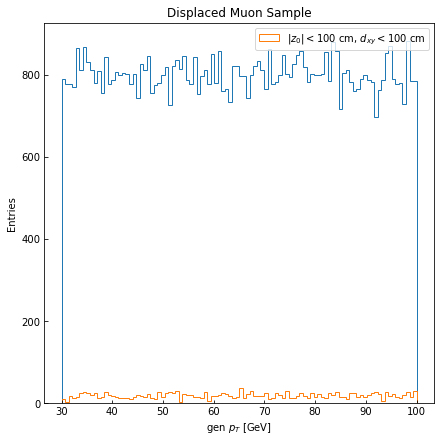

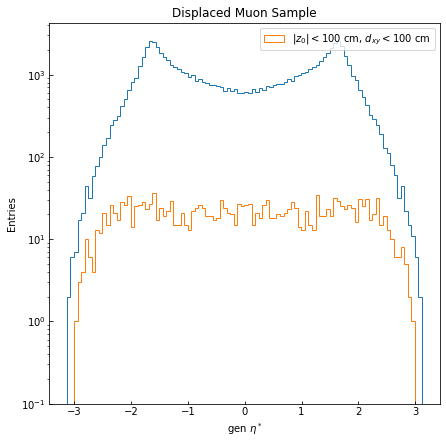

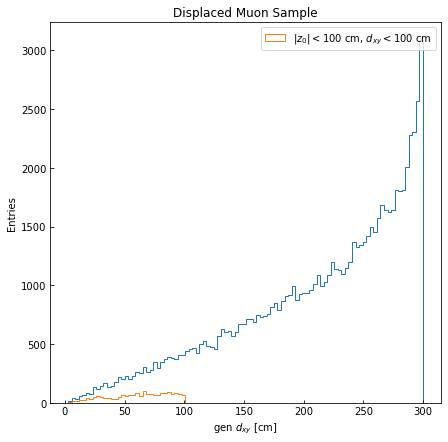

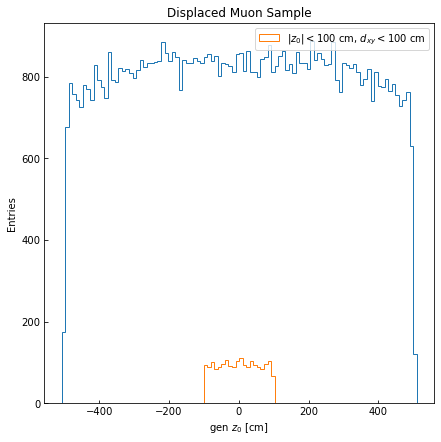

In [12]:
%%time

dm_gen_plus_z0_mask = dm_gen_z0 < 100
dm_gen_minus_z0_mask = dm_gen_z0 > -100
combined_z0_mask = dm_gen_plus_z0_mask & dm_gen_minus_z0_mask

dm_gen_dxy_mask = dm_gen_dxy < 100
combined_z0_dxy_mask = dm_gen_dxy_mask & combined_z0_mask

masked_gen_pt = dm_gen_pt[combined_z0_dxy_mask]

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
n, bins, _ = ax.hist(dm_gen_pt.flatten(), bins=100, histtype='step', align='mid')#, log=True)
n, bins, _ = ax.hist(masked_gen_pt.flatten(), bins=bins, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $p_T$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")
ax.legend()

masked_gen_etastar = dm_gen_etastar[combined_z0_dxy_mask]

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
n, bins, _ = ax.hist(dm_gen_etastar.flatten(), bins=100, histtype='step', align='mid', log=True)
n, bins, _ = ax.hist(masked_gen_etastar.flatten(), bins=bins, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $\eta^*$')
ax.tick_params(direction='in')
# ax.set_xlim(-3,3)
ax.set_title("Displaced Muon Sample")
ax.legend()

masked_gen_dxy = dm_gen_dxy[combined_z0_dxy_mask]

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
n, bins, _ = ax.hist(dm_gen_dxy.flatten(), bins=100, histtype='step', align='mid')#, log=True)
n, bins, _ = ax.hist(masked_gen_dxy.flatten(), bins=bins, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $d_{xy}$ [cm]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")
ax.legend()

masked_gen_z0 = dm_gen_z0[combined_z0_dxy_mask]

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
n, bins, _ = ax.hist(dm_gen_z0.flatten(), bins=100, histtype='step', align='mid')#, log=True)
n, bins, _ = ax.hist(masked_gen_z0.flatten(), bins=bins, histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $z_{0}$ [cm]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")
ax.legend()


We are interested in looking at samples with $|z_0| < 100$ cm and $d_{xy} < 100$ cm. After making those cuts, the distributions look like:

CPU times: user 101 ms, sys: 8.03 ms, total: 109 ms
Wall time: 102 ms


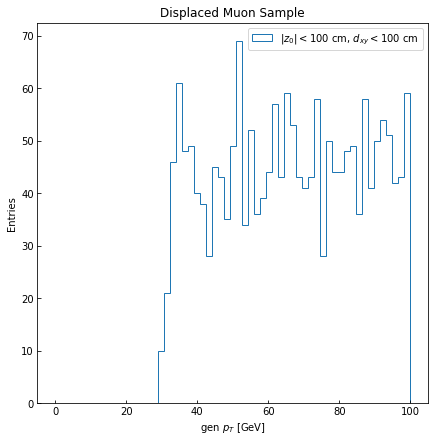

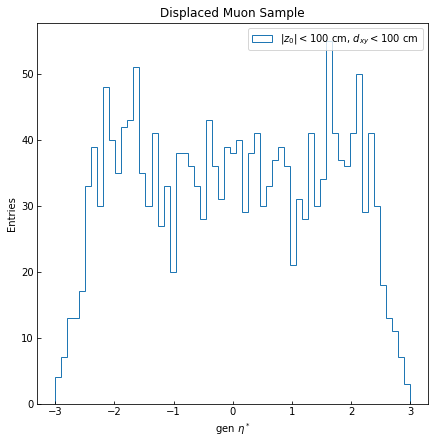

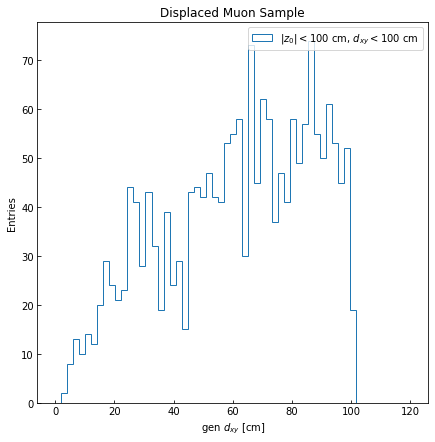

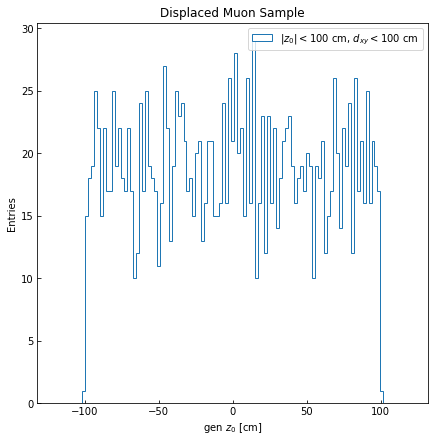

In [46]:
%%time


fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
n, bins, _ = ax.hist(masked_gen_pt.flatten(), bins=np.linspace(0,100,60), histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $p_T$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")
ax.legend()


fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
n, bins, _ = ax.hist(masked_gen_etastar.flatten(), bins=np.linspace(-3,3,60), histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $\eta^*$')
ax.tick_params(direction='in')
# ax.set_xlim(-3,3)
ax.set_title("Displaced Muon Sample")
ax.legend()


fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
n, bins, _ = ax.hist(masked_gen_dxy.flatten(), bins=np.linspace(0,120,60), histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $d_{xy}$ [cm]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")
ax.legend()


fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
n, bins, _ = ax.hist(masked_gen_z0.flatten(), bins=np.linspace(-120,120,120), histtype='step', align='mid', label=r'$|z_0| < 100$ cm, $d_{xy} < 100$ cm')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $z_{0}$ [cm]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")
ax.legend()

## Emulated muons

CPU times: user 101 ms, sys: 5.19 ms, total: 106 ms
Wall time: 101 ms


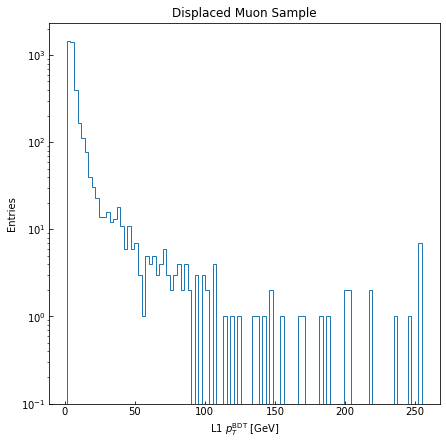

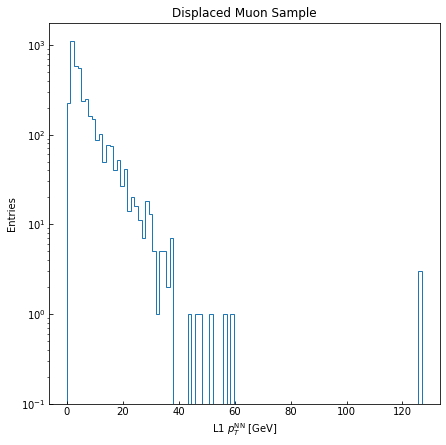

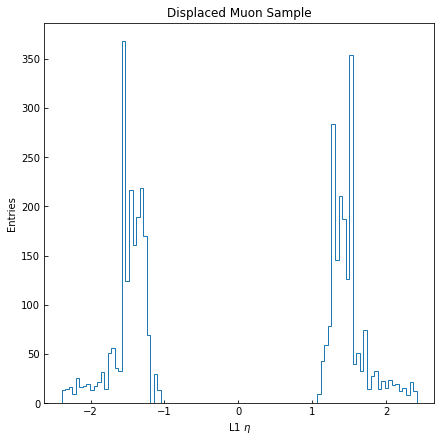

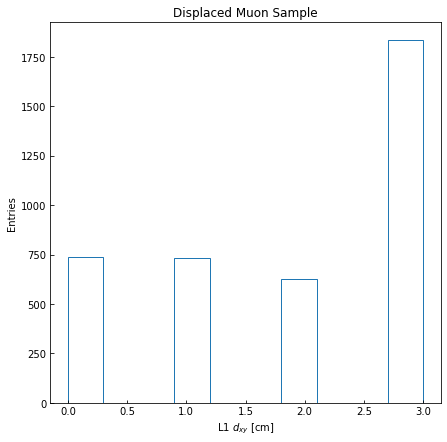

In [14]:
%%time

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(dm_emu_pt_bdt.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(dm_emu_pt_nn.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(dm_emu_eta.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $\eta$')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(dm_emu_dxy.flatten(), histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $d_{xy}$ [cm]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

In [ ]:
dm_matched_emu_pt_bdt = dm_emu_pt_bdt[dm_emu_match]
dm_matched_emu_pt_nn = dm_emu_pt_nn[dm_emu_match]
dm_matched_emu_eta = dm_emu_eta[dm_emu_match]
dm_matched_emu_phi = dm_emu_phi[dm_emu_match]

In [ ]:
# Matched values of gen dxy and gen z0
dm_matched_gen_dxy = dm_gen_dxy[dm_gen_to_emu_match]
dm_matched_gen_z0  = dm_gen_z0[dm_gen_to_emu_match]
dm_matched_gen_pt = dm_gen_pt[dm_gen_to_emu_match]
dm_matched_gen_eta = dm_gen_etastar[dm_gen_to_emu_match]
dm_matched_gen_phi = dm_gen_phistar[dm_gen_to_emu_match]

# Masking matched values of gen dxy and gen z0 for application to emu
dm_matched_gen_z0_plus = dm_matched_gen_z0 < 100
dm_matched_gen_z0_minus = dm_matched_gen_z0 > -100
dm_matched_z0_mask = dm_matched_gen_z0_plus & dm_matched_gen_z0_minus
dm_matched_gen_dxy_mask = dm_matched_gen_dxy < 100
dm_matched_z0_dxy_mask = dm_matched_gen_dxy_mask & dm_matched_gen_dxy_mask

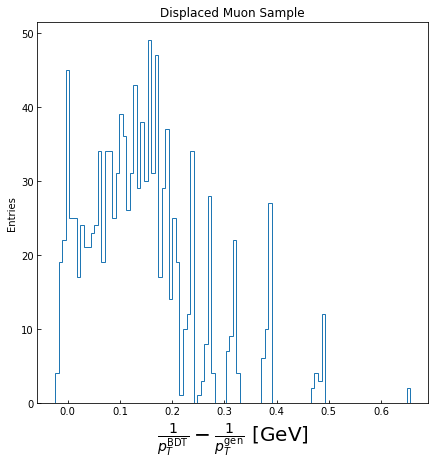

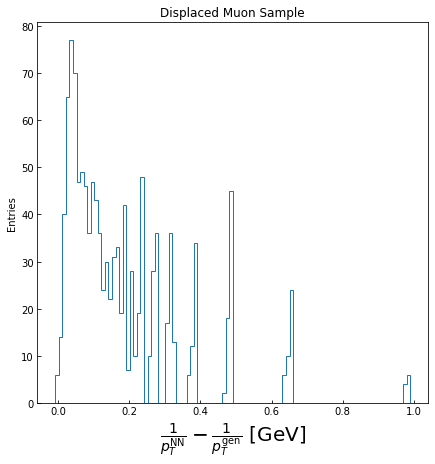

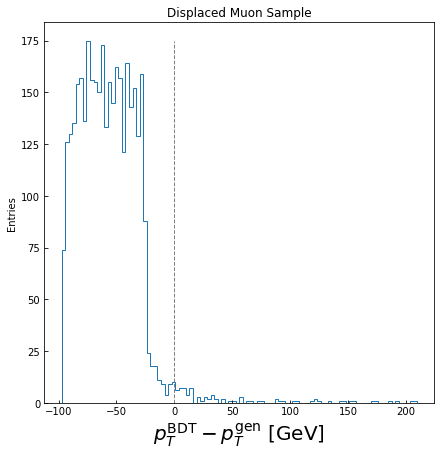

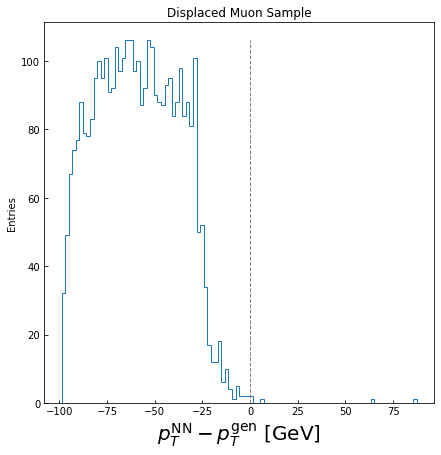

In [43]:
# %%time

dm_gen_inv_pt = []
for i in range(len(dm_gen_pt[gen_match_z0_dxy_mask])):
    temp = dm_gen_pt[i][dm_gen_to_emu_match[i]][dm_matched_z0_dxy_mask[i]].copy()
    temp = temp**-1
    dm_gen_inv_pt.append(temp)
dm_gen_inv_pt = awkward.fromiter(dm_gen_inv_pt)

dm_emu_inv_pt_bdt = []
for i in range(len(dm_emu_pt_bdt[dm_emu_match][dm_matched_z0_dxy_mask])):
    temp = dm_emu_pt_bdt[dm_emu_match][i][dm_matched_z0_dxy_mask[i]].copy()
    temp = temp**-1
    dm_emu_inv_pt_bdt.append(temp)
dm_emu_inv_pt_bdt = awkward.fromiter(dm_emu_inv_pt_bdt)

dm_emu_inv_pt_nn = []
for i in range(len(dm_emu_pt_nn[dm_emu_match])):
    temp = dm_emu_pt_nn[dm_emu_match][i][dm_matched_z0_dxy_mask[i]].copy()
    temp = np.where(temp != 0, temp**-1, temp)
    dm_emu_inv_pt_nn.append(temp)
dm_emu_inv_pt_nn = awkward.fromiter(dm_emu_inv_pt_nn)

bdt_diff_inv_pt = -dm_gen_inv_pt + dm_emu_inv_pt_bdt
nn_diff_inv_pt = -dm_gen_inv_pt + dm_emu_inv_pt_nn


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(bdt_diff_inv_pt.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'$\frac{1}{p_T^{\mathrm{BDT}}} - \frac{1}{p_{T}^{\mathrm{gen}}}$ [GeV]', fontsize=20)
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(nn_diff_inv_pt.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")
ax.set_xlabel(r'$\frac{1}{p_T^{\mathrm{NN}}} - \frac{1}{p_{T}^{\mathrm{gen}}}$ [GeV]', fontsize=20)


bdt_diff = -dm_gen_pt[dm_gen_to_emu_match] + dm_emu_pt_bdt[dm_emu_match]
nn_diff = -dm_gen_pt[dm_gen_to_emu_match] + dm_emu_pt_nn[dm_emu_match]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
n, bins, _ = ax.hist(bdt_diff.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")
ax.set_xlabel(r'$p_T^{\mathrm{BDT}} - p_T^{\mathrm{gen}}$ [GeV]', fontsize=20)
ax.plot([0,0],[0,np.max(n)],color='grey', linestyle='dashed', linewidth=1)


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
n, bins, _ = ax.hist(nn_diff.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")
ax.set_xlabel(r'$p_T^{\mathrm{NN}} - p_{T}^{\mathrm{gen}}$ [GeV]', fontsize=20)
ax.plot([0,0],[0,np.max(n)],color='grey', linestyle='dashed', linewidth=1)

Text(0.5, 1.0, 'LLP $\\mu$ with $d_{xy} < 100$ cm and $|z_0|$ < 100 cm')

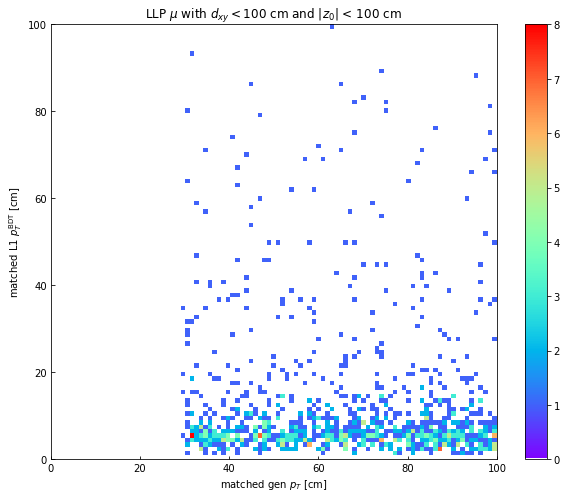

In [42]:
dm_emu_bdt_bins = np.linspace(0, 100, 100)
dm_emu_nn_bins = np.linspace(0, 100, 100)
n, bins, _ = np.histogram2d(dm_matched_gen_pt[dm_matched_z0_dxy_mask].flatten(), dm_emu_pt_bdt[dm_emu_match][dm_matched_z0_dxy_mask].flatten(), bins=(dm_emu_bdt_bins, dm_emu_nn_bins))
X, Y = np.meshgrid(dm_emu_bdt_bins, dm_emu_nn_bins)

fig, ax = plt.subplots(figsize=(10,8))
cmap = change_cmap_bkg_to_white('rainbow')
pcm = ax.pcolormesh(X, Y, n.T, cmap=cmap)#, norm=colors.LogNorm(vmin=1, vmax=np.max(n)), cmap=cmap)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel(r'matched gen $p_T$ [cm]')
ax.set_ylabel(r'matched L1 $p_T^{\mathrm{BDT}}$ [cm]')
ax.tick_params(direction='in')
ax.set_title(r'LLP $\mu$ with $d_{xy} < 100$ cm and $|z_0|$ < 100 cm')


## EMTF Muons

In [ ]:
%%time

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(dm_emtf_pt_global_bdt.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(dm_emtf_pt_nn.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(dm_emtf_global_eta.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $\eta$')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(dm_emtf_global_phi.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $\phi$')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(dm_emtf_dxy.flatten(), histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $d_{xy}$ [cm]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

In [ ]:
dm_matched_emtf_pt_bdt = dm_emtf_pt_bdt[dm_emtf_match]
dm_matched_emtf_pt_nn  = dm_emtf_pt_nn[dm_emtf_match]
dm_matched_emtf_eta    = dm_emtf_eta[dm_emtf_match]
dm_matched_emtf_phi    = dm_emtf_phi[dm_emtf_match]

## Comparison of gen muons to matched emu muons

# Generated LLP Sample

## Generated Muons

CPU times: user 102 ms, sys: 2.01 ms, total: 104 ms
Wall time: 101 ms


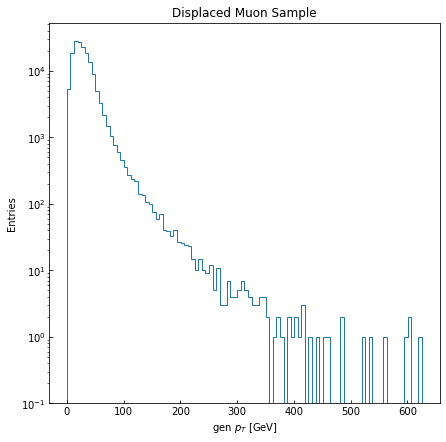

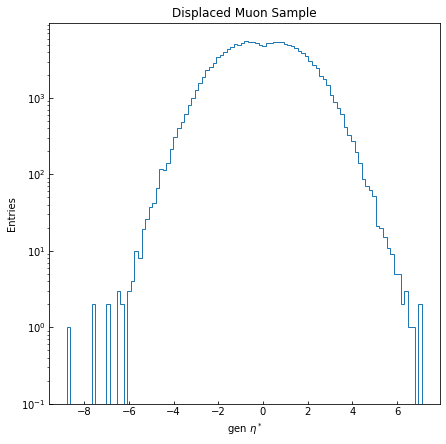

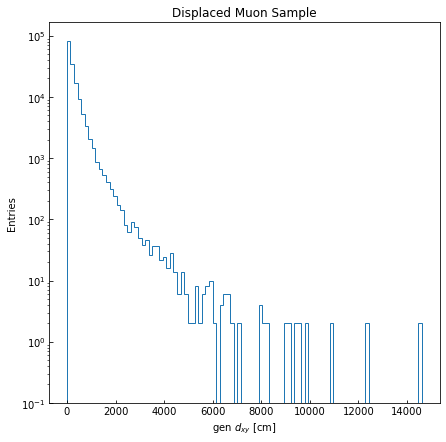

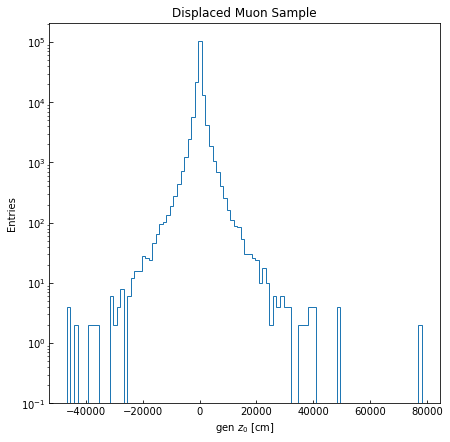

In [38]:
%%time

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_gen_pt.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $p_T$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_gen_etastar.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $\eta^*$')
ax.tick_params(direction='in')
# ax.set_xlim(-3,3)
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_gen_dxy.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $d_{xy}$ [cm]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_gen_z0.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'gen $z_{0}$ [cm]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

## Emulated Muons

CPU times: user 94.5 ms, sys: 7 ms, total: 102 ms
Wall time: 97.2 ms


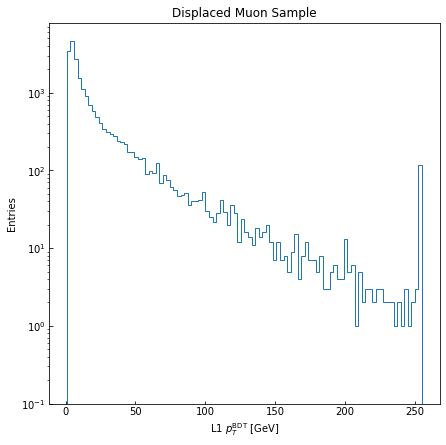

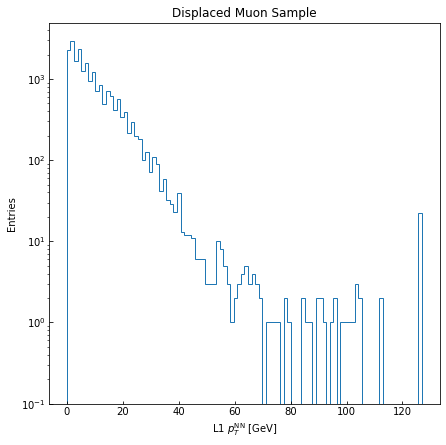

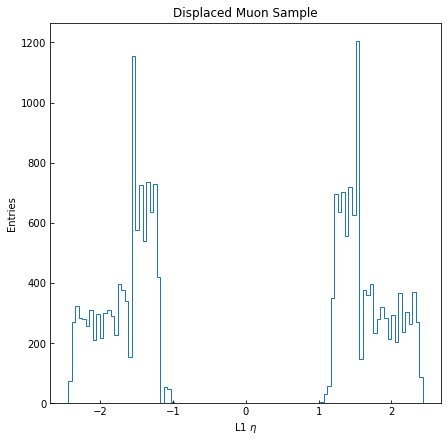

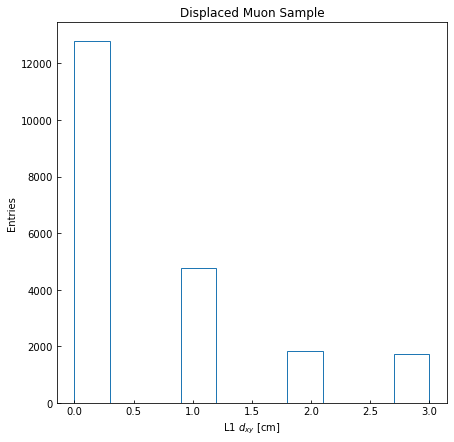

In [39]:
%%time

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_emu_pt_bdt.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_emu_pt_nn.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_emu_eta.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $\eta$')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_emu_dxy.flatten(), histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'L1 $d_{xy}$ [cm]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

## EMTF Muons

CPU times: user 119 ms, sys: 3.03 ms, total: 122 ms
Wall time: 116 ms


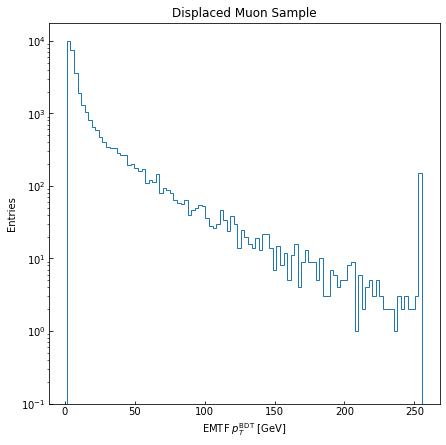

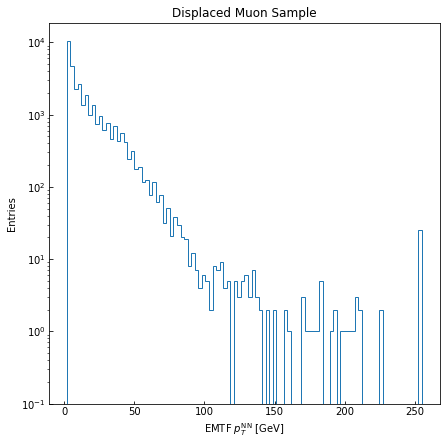

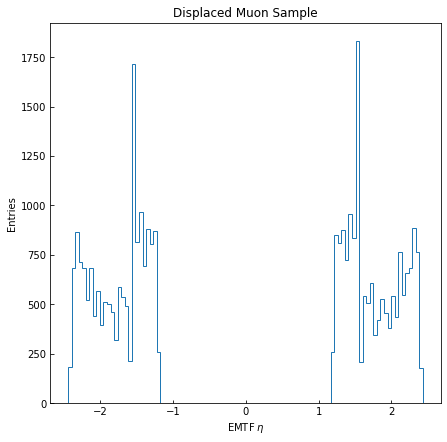

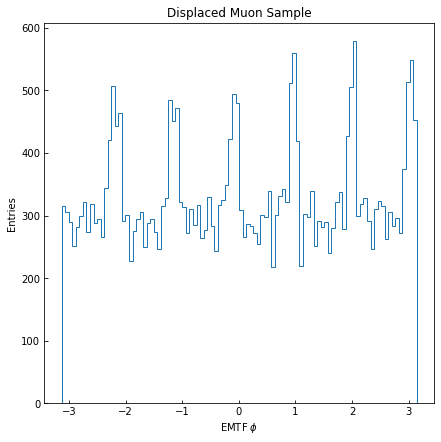

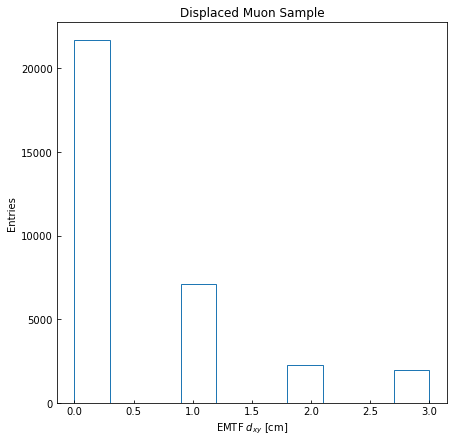

In [40]:
%%time

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_emtf_pt_global_bdt.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $p_T^{\mathrm{BDT}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_emtf_pt_nn.flatten(), bins=100, histtype='step', align='mid', log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $p_T^{\mathrm{NN}}$ [GeV]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_emtf_global_eta.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $\eta$')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_emtf_global_phi.flatten(), bins=100, histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $\phi$')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")

fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.hist(LLP_emtf_dxy.flatten(), histtype='step', align='mid')#, log=True)
ax.set_ylabel(r'Entries')
ax.set_xlabel(r'EMTF $d_{xy}$ [cm]')
ax.tick_params(direction='in')
ax.set_title("Displaced Muon Sample")